In [ ]:
# Install latest version from GitHub
# !pip install -q -U git+https://github.com/jdvelasq/techminer

In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd

from techminer import (
    DataFrame,
    Keywords,
    Plot,
    Thesaurus,
    extract_country,
    heatmap,
    text_clustering,
    prepare_scopus_data,
)

In [2]:
#
# Carga de datos
#
filepath = (
    "https://raw.githubusercontent.com/jdvelasq/techminer/master/data/papers"
    + "urban-agriculture.csv"
)
filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)
df = df.applymap(lambda x: None if pd.isna(x) is True else x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        688 non-null    object 
 1   Author(s) ID                   688 non-null    object 
 2   Title                          688 non-null    object 
 3   Year                           688 non-null    int64  
 4   Source title                   688 non-null    object 
 5   Volume                         602 non-null    object 
 6   Issue                          444 non-null    object 
 7   Art. No.                       132 non-null    object 
 8   Page start                     544 non-null    object 
 9   Page end                       542 non-null    object 
 10  Page count                     9 non-null      float64
 11  Cited by                       453 non-null    float64
 12  DOI                            574 non-null    obj

In [3]:
#
# Scopus data preparation
#
#   1. Change ',' by ';' and remove '.' in author names
#   2. Remove part of title in foreign language
#   3. Keywords = Author Keywords + Index Keywords
#   4. Extract country and affiliation
#
df = prepare_scopus_data(df)

In [4]:
#
# Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

59

In [5]:
#
# Titles of documents without keywords
#
df[df.Keywords.map(lambda x: x is None)]['Title']

11     Structure of urban bioecoagrocentres in contex...
43     Gardening in Times of Urban Transitions: Emerg...
47     Chinampas: An urban farming model of the aztec...
58     Direct and indirect effects of urban gardening...
77     IOP Conference Series: Earth and Environmental...
94     Use-Based Welfare: Property Experiments in Chi...
141                                       Toward sitopia
206    IOP Conference Series: Earth and Environmental...
225                          Politics of urban gardening
275    Integrated vertical aeroponic farming systems ...
284    Brucellosis in livestock and wildlife: Zoonoti...
286    Urban gardening between agency and structure: ...
322    Land tenure for urban farming: Toward a scalab...
335    Political consumers as digital food activists?...
336                     Urban sustainability transitions
341    Good food, strong communities: Promoting socia...
359                               Urban farming movement
384         Low lead poisoning 

In [6]:
#
# Build keywords from other papers
#
keywords = Keywords(df.Keywords[df.Keywords.map(lambda w: w is not None)], sep=';')
keywords = keywords.compile()
title_abstract = df.Title + df.Abstract
opt_keywords = title_abstract.map(lambda w: keywords.extract_from_text(w))

# check
opt_keywords[df.Keywords.map(lambda w: w is None)].head()

11    accessibility;air;article;cities;city;context;...
43    Cultivation;Entrepreneur;Garden;Gardening;New ...
47    China;City;Farmers;Horticultural;Science;Urban...
58    Soil moisture;Switzerland;Urban gardens;abunda...
77    Environment;Environmental;Environmental Scienc...
dtype: object

In [7]:
#
# Assign new keywords
#
df.at[df.Keywords.map(lambda w: w is None), 'Keywords'] = opt_keywords[df.Keywords.map(lambda w: w is None)]

#
# Check: Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

0

In [8]:
#
# Text clustering of keywords.
#   Keyword strings with the same number of words
#
thesaurus = text_clustering(df.Keywords, sep=";", transformer=lambda x: x.lower())
with open("urban-agriculture-raw.json", "w") as f:
    f.write(thesaurus.__repr__())

In [9]:
!head -n 20 urban-agriculture-raw.json

{
  "abiotic factors": [
    "Abiotic factors",
    "abiotic factor"
  ],
  "abortion, veterinary": [
    "Abortion, Veterinary",
    "veterinary abortion"
  ],
  "acceptance": [
    "Acceptance",
    "acceptance"
  ],
  "accra, ghana": [
    "Accra, Ghana",
    "Accra-Ghana"
  ],
  "action research": [
    "Action research",
    "action research",


In [10]:
#
# Keywords cleaning
#
f = thesaurus.to_dict()
df['Keywords'] = df.Keywords.map(lambda x: ';'.join([f[w] for w in x.split(';') if w in f]))

#
#   Remove extra blanks between keywords if exists
#
df["Keywords"] = df.Keywords.map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

#
#   Replace empty strings by None
#
df["Keywords"] = df.Keywords.map(lambda x: x if x != "" else None)

#
#   Number of unique of strings
#
len(
    set([w.strip() for x in df.Keywords if x is not None for w in x.split(";")])
)

848

In [11]:
#
# A column for identify each record is added to the dataframe.
#
df = DataFrame(df).generate_ID()

In [12]:
#
# Number of terms
#
df.descriptive_stats()

,Value
Description,
Articles,688.000000
First year,1984.000000
Last year,2020.000000
Average citations per article,15.320088
Authors,1870.000000
Author(s) ID,1859.000000
Authors of single authored articles,192.000000
Authors of multi authored articles,496.000000
Articles per author,0.370000


In [13]:
#
# Author desambiguation
#
df = DataFrame(df).disambiguate_authors()

In [14]:
#
# Top 10 most frequent authors
#
sorted(df.documents_by_term('Authors').head(10).Authors)

['Asomani-Boateng R',
 'Certoma C',
 'Cisse G',
 'Lehmann S',
 'Polling B',
 'Randhawa MA',
 'Specht K',
 'Tan HTW',
 'Utzinger J',
 '[No author name available]']

In [15]:
#
# Top 10 most cited authors
#
sorted(df.citations_by_term('Authors').head(10).Authors)

['Barthel S',
 'Cisse G',
 'Gianquinto G',
 'Matthys B',
 'McClintock N',
 "N'Goran EK",
 'Nasr J',
 'Smit J',
 'Utzinger J',
 'Vounatsou P']

In [16]:
#
# Top 10 most frequent keywords
#
df.documents_by_term("Keywords", sep=";").head(10)

,Keywords,Num Documents,ID
0,urban agriculture,203,"[0, 3, 4, 7, 8, 9, 20, 26, 27, 31, 32, 36, 46,..."
1,urban farm,180,"[9, 17, 21, 22, 24, 26, 33, 34, 35, 43, 47, 49..."
2,urban garden,112,"[1, 7, 13, 14, 20, 32, 39, 43, 58, 77, 89, 96,..."
3,garden,101,"[4, 6, 19, 20, 40, 43, 58, 64, 77, 85, 89, 91,..."
4,urban,99,"[11, 43, 47, 58, 67, 77, 81, 85, 94, 118, 141,..."
5,urban areas,99,"[3, 4, 5, 6, 13, 16, 28, 44, 60, 64, 85, 88, 1..."
6,agriculture,93,"[7, 24, 27, 29, 42, 47, 49, 53, 62, 70, 95, 10..."
7,sustainability,70,"[9, 23, 38, 45, 47, 57, 62, 67, 74, 78, 79, 81..."
8,article,62,"[3, 4, 11, 19, 28, 60, 64, 88, 94, 106, 121, 1..."
9,food security,61,"[9, 38, 48, 49, 53, 63, 65, 82, 124, 131, 154,..."


In [17]:
#
# Top 10 most cited keywords
#
df.citations_by_term("Keywords", sep=";").head(10)

,Keywords,Cited by,ID
0,urban agriculture,3125,"[0, 3, 4, 7, 8, 9, 20, 26, 27, 31, 32, 36, 46,..."
1,urban farm,1509,"[9, 17, 21, 22, 24, 26, 33, 34, 35, 43, 47, 49..."
2,urban areas,1327,"[3, 4, 5, 6, 13, 16, 28, 44, 60, 64, 85, 88, 1..."
3,food security,1208,"[9, 38, 48, 49, 53, 63, 65, 82, 124, 131, 154,..."
4,garden,1198,"[4, 6, 19, 20, 40, 43, 58, 64, 77, 85, 89, 91,..."
5,article,1139,"[3, 4, 11, 19, 28, 60, 64, 88, 94, 106, 121, 1..."
6,urban,1090,"[11, 43, 47, 58, 67, 77, 81, 85, 94, 118, 141,..."
7,urban garden,1087,"[1, 7, 13, 14, 20, 32, 39, 43, 58, 77, 89, 96,..."
8,agriculture,991,"[7, 24, 27, 29, 42, 47, 49, 53, 62, 70, 95, 10..."
9,sustainability,934,"[9, 23, 38, 45, 47, 57, 62, 67, 74, 78, 79, 81..."


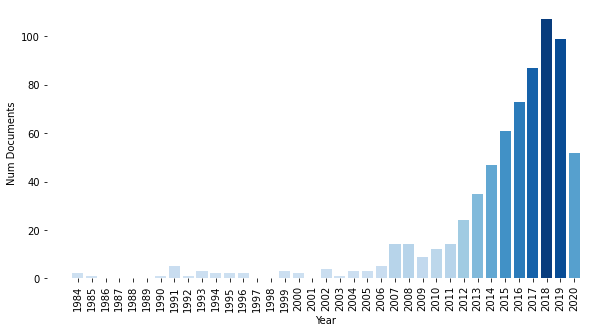

In [21]:
#
# Documents by year
#
plt.figure(figsize=(10,5))
Plot(df.documents_by_year()).bar(cmap=plt.cm.Blues)

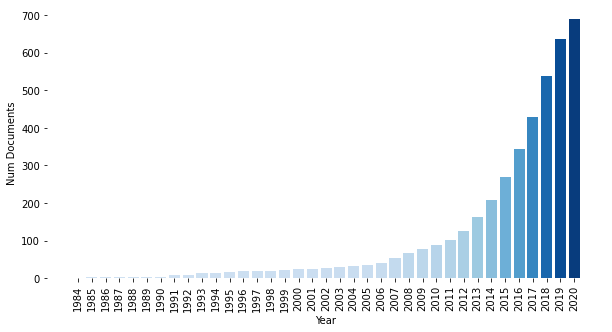

In [25]:
#
# Cumulative number of documents by year
#
plt.figure(figsize=(10,5))
Plot(df.documents_by_year(cumulative=True)).bar(cmap=plt.cm.Blues)

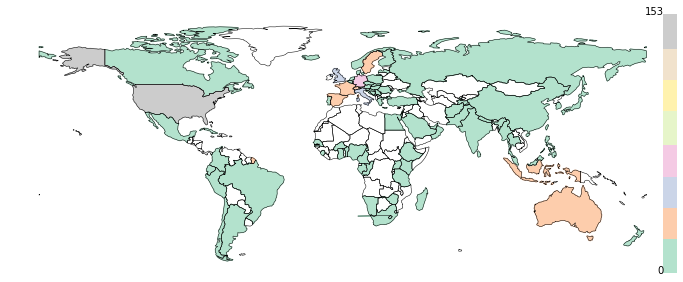

In [26]:
#
# Worldmap with the number of documents by country
#
df["Country"] = df["Affiliations"].map(lambda x: extract_country(x, sep=";"))
plt.figure(figsize=(12,5))
Plot(df.documents_by_term("Country", sep=";")).worldmap()
plt.show()

In [30]:
df.documents_by_term('Country', sep=';').head(20)

,Country,Num Documents,ID
0,United States,153,"[4, 5, 27, 31, 38, 40, 42, 43, 46, 47, 48, 62,..."
1,Germany,68,"[7, 19, 20, 27, 37, 42, 54, 57, 58, 60, 68, 79..."
2,Italy,46,"[42, 44, 45, 51, 79, 97, 119, 134, 136, 152, 1..."
3,United Kingdom,40,"[26, 42, 49, 53, 67, 116, 128, 135, 137, 154, ..."
4,Indonesia,29,"[12, 15, 17, 18, 24, 52, 61, 63, 113, 131, 151..."
5,France,27,"[8, 86, 87, 147, 164, 168, 190, 210, 219, 223,..."
6,Switzerland,25,"[6, 58, 70, 73, 106, 160, 181, 194, 198, 217, ..."
7,Spain,22,"[1, 13, 59, 74, 91, 99, 101, 126, 153, 169, 20..."
8,Australia,21,"[2, 3, 9, 53, 124, 161, 187, 204, 333, 336, 36..."
9,Sweden,20,"[56, 78, 93, 273, 301, 311, 376, 429, 434, 446..."


In [33]:
df.documents_by_term('Institution', sep=';').head(10)

,Institution,Num Documents,ID
0,,420,"[8, 9, 11, 12, 15, 17, 18, 19, 22, 23, 24, 28,..."
1,Institute of Biology,5,"[58, 106, 160, 194, 307]"
2,Institute of Terrestrial Ecosystems,4,"[58, 106, 160, 194]"
3,National Institute of Food Science and Technology,4,"[247, 370, 430, 517]"
4,Research Institute of Organic Agriculture (FiBL),4,"[58, 106, 160, 194]"
5,Swiss Federal Research Institute WSL,4,"[58, 106, 160, 194]"
6,Swiss Tropical Institute,4,"[607, 610, 641, 648]"
7,COMSATS Institute of Information Technology,3,"[370, 430, 516]"
8,Institute of Socio-Economics,3,"[383, 412, 451]"
9,International Livestock Research Institute,3,"[162, 256, 358]"
